In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='ticks', context='talk')
import glob, warnings, itertools
%matplotlib inline


In [422]:
path = r'C:\\Users\\jpisel\\Downloads\\pickups\\'
allFiles=glob.glob(path+"*.csv")
frame=pd.DataFrame
listed=[]
for file in allFiles:
    df = pd.read_csv(file, index_col=[0], parse_dates=[0], header=None)
    listed.append(df)
frame = pd.concat(listed)



In [424]:
frame.columns=['company']
frame['counts']=1

In [425]:
frame['lyft']=frame['company']=='Lyft'
frame['uber']=frame['company']=='Uber'
lyfted=frame.query('lyft == True ')
ubered=frame.query('uber == True')

In [426]:
ubered.head()

,company,counts,lyft,uber
0,,,,
2016-08-01 00:00:06,Uber,1,False,True
2016-08-01 00:00:17,Uber,1,False,True
2016-08-01 00:00:21,Uber,1,False,True
2016-08-01 00:00:34,Uber,1,False,True
2016-08-01 00:01:22,Uber,1,False,True


In [429]:
new=frame.resample('d').sum()
new.head()

,counts,lyft,uber
0,,,
2016-06-13,101,0.0,101.0
2016-06-14,134,0.0,134.0
2016-06-15,133,0.0,133.0
2016-06-16,140,0.0,140.0
2016-06-17,177,24.0,153.0


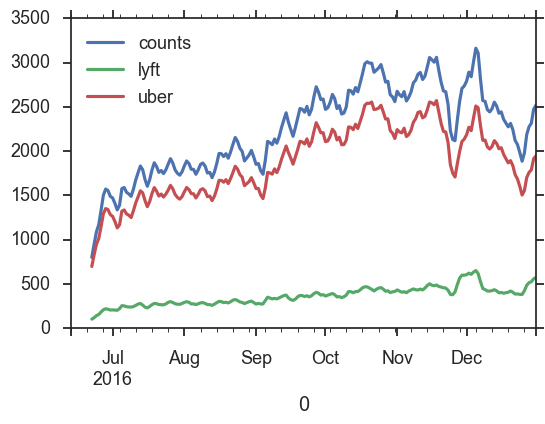

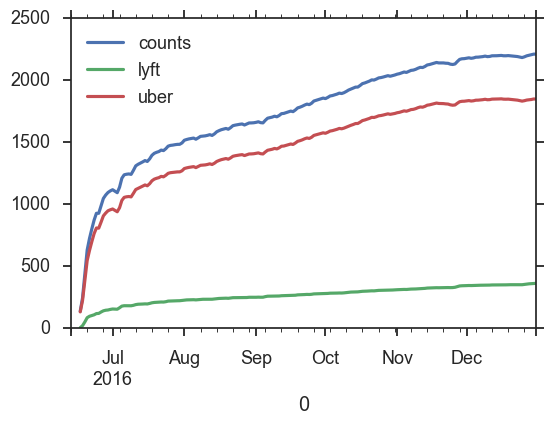

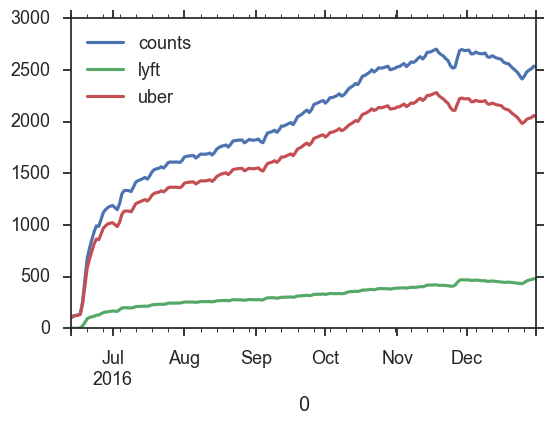

In [430]:
new.rolling(10).mean().plot(label='rolling')
new.expanding(5).mean().plot(label='expanding')
new.ewm(alpha=0.03).mean().plot(label='emwa')

In [431]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [435]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(new['lyft'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 7)12 - AIC:2756.0847631676843
ARIMA(0, 0, 0)x(0, 1, 1, 7)12 - AIC:2354.2417195494136
ARIMA(0, 0, 0)x(1, 0, 0, 7)12 - AIC:2538.8013884194233
ARIMA(0, 0, 0)x(1, 0, 1, 7)12 - AIC:2413.8440791574358
ARIMA(0, 0, 0)x(1, 1, 0, 7)12 - AIC:2384.0562016968875
ARIMA(0, 0, 0)x(1, 1, 1, 7)12 - AIC:2347.830811910844
ARIMA(0, 0, 1)x(0, 0, 0, 7)12 - AIC:2759.8504567680966
ARIMA(0, 0, 1)x(0, 0, 1, 7)12 - AIC:2572.3819253920065
ARIMA(0, 0, 1)x(0, 1, 0, 7)12 - AIC:2398.741756248852
ARIMA(0, 0, 1)x(0, 1, 1, 7)12 - AIC:2231.525426082287
ARIMA(0, 0, 1)x(1, 0, 0, 7)12 - AIC:2425.6836388014553
ARIMA(0, 0, 1)x(1, 0, 1, 7)12 - AIC:2301.479521016301
ARIMA(0, 0, 1)x(1, 1, 0, 7)12 - AIC:2277.486273097925
ARIMA(0, 0, 1)x(1, 1, 1, 7)12 - AIC:2229.895945936738
ARIMA(0, 1, 0)x(0, 0, 1, 7)12 - AIC:2428.57016320791
ARIMA(0, 1, 0)x(0, 1, 1, 7)12 - AIC:2250.597446774784
ARIMA(0, 1, 0)x(1, 0, 0, 7)12 - AIC:2402.4293912153607
ARIMA(0, 1, 0)x(1, 0, 1, 7)12 - AIC:2332.9032658281335
ARIMA(0, 1, 0)x(1, 

In [437]:
mod = sm.tsa.statespace.SARIMAX(new['lyft'], order=(1,1,1), seasonal_order=(0,1,1,7), 
                                enforce_stationarity=False, enforce_invertibility=False)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5344      0.189     -2.829      0.005      -0.905      -0.164
ma.L1          0.6918      0.172      4.012      0.000       0.354       1.030
ma.S.L7       -0.8659      0.045    -19.332      0.000      -0.954      -0.778
sigma2      9722.1768    612.220     15.880      0.000    8522.247    1.09e+04


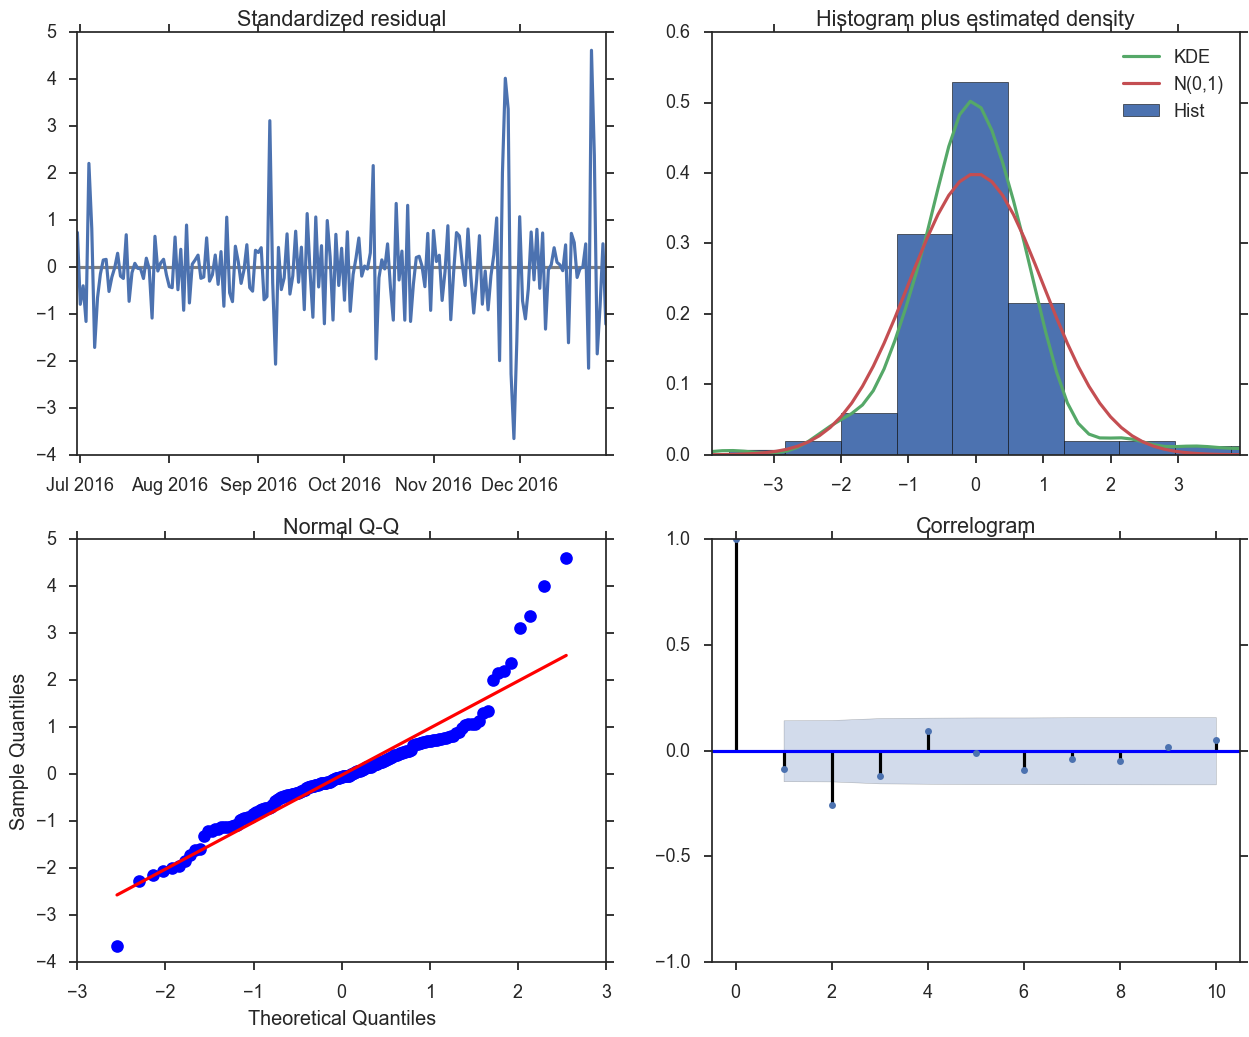

In [438]:
results = mod.fit()

print(results.summary().tables[1])
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [439]:
forecast_start='2016-11-01'
forecast_end='2016-12-31'
pred = results.get_prediction(start=forecast_start)
pred_ci = pred.conf_int()

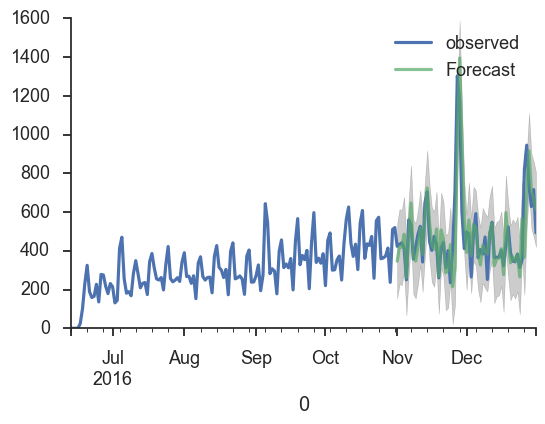

In [441]:
ax = new['lyft'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()
sns.despine()

In [443]:
from sklearn import metrics
y_forecasted=pred.predicted_mean[forecast_start:forecast_end]
y_truth=new['lyft'][forecast_start:forecast_end]
#Compute mean absolute error
metrics.mean_absolute_error(y_truth,y_forecasted)

92.286077194330645

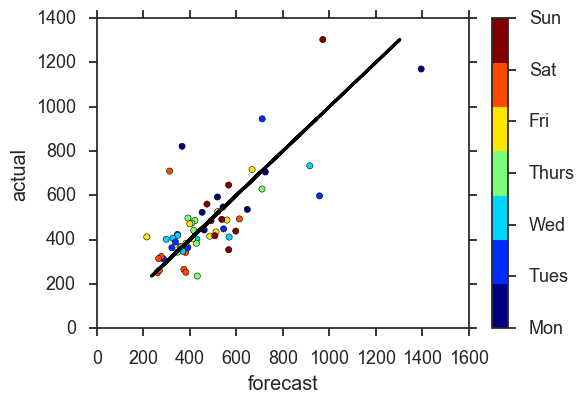

In [444]:
dayofweek = pd.to_datetime(y_forecasted.index).dayofweek

plt.scatter(y_forecasted,y_truth, c=dayofweek, cmap=plt.cm.get_cmap('jet', 7))
plt.plot(y_truth, y_truth,'k-') # identity line
plt.xlabel('forecast')
plt.ylabel('actual')
cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])

In [448]:
from pandas.tseries.holiday import USFederalHolidayCalendar
calen = USFederalHolidayCalendar()
holidays = calen.holidays('2016', '2017', return_name=True)

allholidays = pd.concat([holidays,
                         "Day Before " + holidays.shift(-1, 'D'),
                         "Day After " + holidays.shift(1, 'D')])
allholidays = allholidays.sort_index()
allholidays.tail()

2016-11-24              Thanksgiving
2016-11-25    Day After Thanksgiving
2016-12-25      Day Before Christmas
2016-12-26                 Christmas
2016-12-27       Day After Christmas
dtype: object

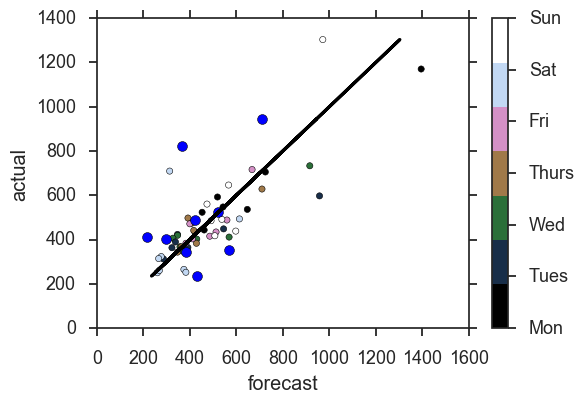

In [449]:
dates=allholidays.index
dayofweeks = pd.to_datetime(y_forecasted.index).dayofweek

plt.scatter(y_forecasted,y_truth, c=dayofweeks, cmap=plt.cm.get_cmap('cubehelix', 7))
plt.plot(y_truth, y_truth,'k-') # identity line
plt.xlabel('forecast')
plt.ylabel('actual')
dayofweeks = pd.to_datetime(y_forecasted.index).dayofweek
cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])

plt.scatter(y_forecasted.loc[dates], y_truth.loc[dates], c='b',s=50)


126.47697605656495

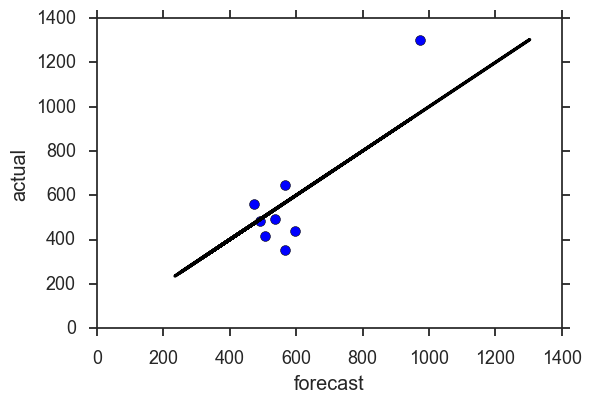

In [450]:
dazed=np.where(dayofweeks==6)
dates=allholidays.index
plt.plot(y_truth, y_truth,'k-') # identity line
plt.xlabel('forecast')
plt.ylabel('actual')
plt.scatter(y_forecasted.iloc[dazed], y_truth.iloc[dazed], c='b',s=50)
metrics.mean_absolute_error(y_truth.iloc[dazed], y_forecasted.iloc[dazed])

In [451]:
pred_dy = results.get_prediction(start='2016-07-01', dynamic=forecast_start)
pred_dy_ci = pred_dy.conf_int()

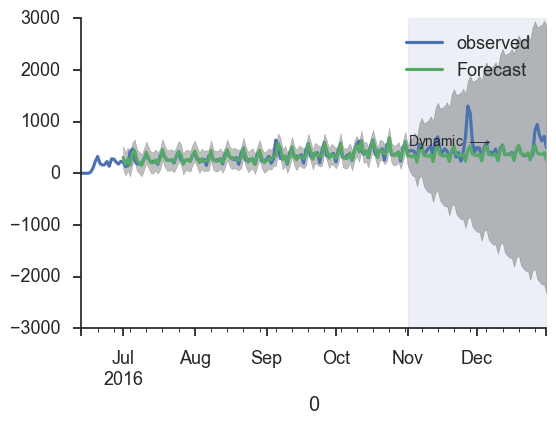

In [453]:
ax = new['lyft'].plot(label='observed')
pred_dy.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_dy_ci.index,
                pred_dy_ci.iloc[:, 0],
                pred_dy_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.Timestamp(forecast_start), new.index[-1],
                 alpha=.1, zorder=-1)
ax.annotate('Dynamic $\\longrightarrow$', (pd.Timestamp(forecast_start), 550))

plt.legend()
sns.despine()